In [2]:
import numpy as np
import pandas as pd
import csv
import nltk
import re
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from nltk.corpus import stopwords 
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

### Preprocessing text
reading in files from my own local dirs, all of these directories are available in the repo so please replace the paths

In [3]:
annotations_lib = "/Users/katherineqian/Desktop/rsch/Privacy Policy Corpus/consolidation/threshold-0.5-overlap-similarity/"
text_lib = "/Users/katherineqian/Desktop/rsch/Privacy Policy Corpus/txt_policies/"
desktop = "/Users/katherineqian/Desktop/"
allfiles = [f[:-4] for f in listdir(annotations_lib) if isfile(join(annotations_lib, f))]

#learning_corpus = ["20_theatlantic.com", "21_imdb.com", "26_nytimes.com", "32_voxmedia.com", "33_nbcuniversal.com", "58_esquire.com", "59_liquor.com", "70_meredith.com", "82_sheknows.com", "93_pbs.org"]

learning_corpus = allfiles[:85]
#learning_corpus = ["928_stlouisfed.org"]
testing_corpus = allfiles[85:]

# doc2vec model generation
I did the TFIDF and doc2vec separately. Some of the text preprocessing could be consolidated, but I kept them separate here. You can run the doc2vec code once and export the models to ".model" files, then use those model files for future calculations by importing them to get more consistent results. 

### make a dict of lists of the tokens. 
'policyname': ['split', 'tokens', 'apple', etc.]


In [4]:
policies_split = {}

for policy in allfiles:
    with open(text_lib + policy + ".txt", 'r', encoding="utf8", errors='ignore') as infile:
        clean_text = re.sub('[\n]', ' ', infile.read())
        #strip URLs
        clean_text = re.sub('https?:\/\/','<URL>', clean_text)
        # strip html tags
        clean_text = re.sub('<br>|<ul>|<li>|</ul>|</li>|<strong>|</strong>', '', clean_text)
        # strip random stuff i dont want lol
        clean_text = re.sub('[\ufeff]', '', clean_text)
        clean_text = re.sub('[""]', '', clean_text)

        # split by ||| delimiter
        partokens = clean_text.split("|||")
        policies_split[policy] = partokens

#print(policies_split)
#print(policies_split['21_imdb.com'])

In [5]:
# scrapped using panda because making dataframe for each csv is too slow to copy
# https://stackoverflow.com/questions/31674557/how-to-append-rows-in-a-pandas-dataframe-in-a-for-loop

columns = ['paragraph_num', 'rawtxt', 'label', 'policy']
chunks_tagged = []
# getting raw sentence from the txt files
now = 0
prev = None
for policy in allfiles:
    with open(annotations_lib + policy + ".csv", mode='r') as infile:
        reader = csv.reader(infile)
        for rows in reader:
            paragraph_num = int(rows[4])
            # OPTIONAL: ONLY TAKE FIRST ANNOTATION
            now = paragraph_num
            if now == prev:
                continue
                
            temp = [paragraph_num, policies_split[policy][paragraph_num], rows[5], policy]
            chunks_tagged.append(temp)
            prev = now
            

alldf = pd.DataFrame(chunks_tagged, columns=columns)

from nltk.corpus import stopwords 

stop_words = set(stopwords.words('english')) 

# standard tokenizing function
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if word in stop_words:
                continue
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

tags_indexed = {'First Party Collection/Use': 1 , 'Third Party Sharing/Collection': 2, 'User Choice/Control': 3, 'User Access, Edit and Deletion': 4, 'Data Retention': 5, 'Data Security': 6, 'Policy Change': 7, 'Do Not Track': 8, 'International and Specific Audiences': 9, 'Introductory/Generic': 10, 'Practice Not Covered': 11, 'Privacy Contact Information': 12, 'Other': 13}
tags_backward = {1:'First Party Collection/Use' , 2: 'Third Party Sharing/Collection', 3: 'User Choice/Control', 4: 'User Access, Edit and Deletion', 5: 'Data Retention', 6: 'Data Security', 7: 'Policy Change', 8: 'Do Not Track', 9: 'International and Specific Audiences', 10: 'Introductory/Generic', 11: 'Practice Not Covered', 12: 'Privacy Contact Information', 13: 'Other'}

def create_tagged_tokens(row, dest):
    tokens = tokenize_text(row['rawtxt'])
    label = row['label']
    # change tagged document to tuple because this application has no classifier
    policy = row['policy']
    dest.append(TaggedDocument(words = tokens, tags = [tags_indexed.get(label, 13)]))
    return row

def tokens_with_policy(row, dest):
    tokens = tokenize_text(row['rawtxt'])
    label = row['label']
    # change tagged document to tuple because this application has no classifier
    policy = row['policy']
    dest.append((tokens, tags_indexed.get(label, 13), policy))
    return row

all_docs_tagged = []
all_docs = []

alldf.apply(create_tagged_tokens, axis = 1, args=[all_docs_tagged])
alldf.apply(tokens_with_policy, axis = 1, args=[all_docs])
print("Finished converting the data.")

Finished converting the data.


In [6]:
print(all_docs[85])
alldf

(['privacy', 'policy'], 13, '701_tangeroutlet.com')


,paragraph_num,rawtxt,label,policy
0,0,"Effective Date: May 7, 2015 Kraft Site Priva...",Other,746_kraftrecipes.com
1,1,Information We Collect Personally-Identifia...,First Party Collection/Use,746_kraftrecipes.com
2,2,Registration To take full advantage of our ...,First Party Collection/Use,746_kraftrecipes.com
3,3,"Contests, Sweepstakes and Games We may prov...",First Party Collection/Use,746_kraftrecipes.com
4,4,"E-mail When you ask us to send you recipes,...",First Party Collection/Use,746_kraftrecipes.com
...,...,...,...,...
3785,24,If you no longer wish to receive our announcem...,Other,1545_taylorswift.com
3786,25,What is our policy on tracking? You may be ...,Do Not Track,1545_taylorswift.com
3787,26,We do not participate in tracking networks and...,Other,1545_taylorswift.com
3788,27,Does this Policy apply in other countries? ...,Other,1545_taylorswift.com


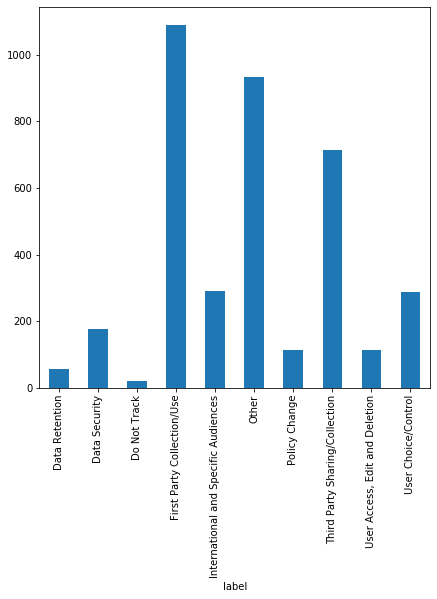

In [7]:
from matplotlib import rcParams

fig = plt.figure(figsize=(7,7))

alldf.groupby('label').rawtxt.count().plot.bar(ylim=0)
#print(testdf.groupby('label').rawtxt.count())
#plt.savefig('traindistribution.png', dpi=100)
plt.show()
#%matplotlib notebook

### Training models (do not need to touch)

In [8]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import utils

from tqdm import tqdm
import multiprocessing

cores = multiprocessing.cpu_count()

#model_dbow = Doc2Vec(dm=1, alpha=0.025, min_alpha=0.025)

model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_docs_tagged)])

100%|██████████| 3791/3791 [00:00<00:00, 2682741.09it/s]


In [9]:
for epoch in range(30):
    if epoch % 2 == 0:
        print('working on epoch', epoch)
    model_dbow.train(utils.shuffle([x for x in all_docs_tagged]), total_examples=len(all_docs_tagged), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

print("Done.")

working on epoch 0
working on epoch 2
working on epoch 4
working on epoch 6
working on epoch 8
working on epoch 10
working on epoch 12
working on epoch 14
working on epoch 16
working on epoch 18
working on epoch 20
working on epoch 22
working on epoch 24
working on epoch 26
working on epoch 28
Done.


In [10]:
model_dmm = Doc2Vec(dm=0, dm_mean=1, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores, alpha=0.065, min_alpha=0.065)

model_dmm.build_vocab([x for x in tqdm(all_docs_tagged)])
for epoch in range(30):
    if epoch % 2 == 0:
        print('working on epoch', epoch)
    model_dmm.train(utils.shuffle([x for x in all_docs_tagged]), total_examples=len(all_docs), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

print("Done.")

100%|██████████| 3791/3791 [00:00<00:00, 1678164.27it/s]


working on epoch 0
working on epoch 2
working on epoch 4
working on epoch 6
working on epoch 8
working on epoch 10
working on epoch 12
working on epoch 14
working on epoch 16
working on epoch 18
working on epoch 20
working on epoch 22
working on epoch 24
working on epoch 26
working on epoch 28
Done.


In [11]:
# delete temporary training data to free up RAM
model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

note: in my thesis the concatenated model performed best compared to both the dbow and dmm models when using logistic regression to classify text into categories. Here is a copy of the results (PV = paragraph vector)

| Model | Accuracy |
| :--- | --- |
| PV-DM | 59.53% |
| PV-DBOW | 59.07% |
| Concatenated Model | 61.36% |

In [12]:
# concatenate 2 models
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
concat = ConcatenatedDoc2Vec([model_dbow, model_dmm])

In [13]:
# for fun testing part, you can type below
# this currently doesn't work because we didn't use a classifier for this but useful to double check vector shape
rawtest = "security rocks our socks and we secure data seriously"

blah = tokenize_text(rawtest)
vector = concat.infer_vector(blah)

In [14]:
vector.shape

(600,)

In [15]:
# save models you can import later
model_dbow.save("100420_dbow.model")
model_dmm.save("100420_dmm.model")

### Calculate vectors
new method 09/22 - bag of words + vectors:
* corpus 
* policy
* categories
* categories within policies
* every text segment in policies

compare policy to corpus, categories in policies to categories, text segments to categories

In [16]:
corpus_bag = []
category_bags = {category: [] for category in range(1,14)} 
category_vectors = {category: [] for category in range(1,14)} 

for doc in all_docs[1:]:
    corpus_bag.extend(doc[0])
    category_bags[doc[1]].extend(doc[0])

# find overall corpus vector
corpus_vector = concat.infer_vector(corpus_bag)

# find vector for each category
for idx in category_bags:
    category_vectors[idx] = concat.infer_vector(category_bags[idx])

In [17]:
test_small = ["531_archives.gov", "1306_chasepaymentech.com", "517_kaleidahealth.org", "701_tangeroutlet.com", "1618_sltrib.com", "1683_dailynews.com"]
test_list = ["531_archives.gov","1306_chasepaymentech.com", "517_kaleidahealth.org", "701_tangeroutlet.com", "1683_dailynews.com", "1618_sltrib.com","591_google.com","105_amazon.com", "303_reddit.com", "1300_bankofamerica.com", "1470_steampowered.com", "135_instagram.com", "26_nytimes.com"]

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

cos_sims = {}
# each policy is a key, list is value with index corresponding to sentence no.
sentence_sims = {"746_kraftrecipes.com":[]}

# similarity of sentences in each category
category_sims = {category: [] for category in range(1,14)} 

# bag of words for entire policy
policy_bag = []

# bag of words for every category within a policy
intra_policy_bags = {"746_kraftrecipes.com": {i:[] for i in range(1,14)}}

sentence_count = 0

previous_policy = "746_kraftrecipes.com" # starting policy LOL
# assume that all of the docs are in order... which they are but still... kinda jank

for paragraph in all_docs[1:]:
    current_policy = paragraph[2]
        
    if current_policy == previous_policy:
        policy_bag.extend(paragraph[0])
        intra_policy_bags[current_policy][paragraph[1]].extend(paragraph[0])
        
        # calculate similarity to category
        sentence_vector = concat.infer_vector(paragraph[0])
        cat_sim = cosine_similarity(sentence_vector.reshape(1, -1), category_vectors[paragraph[1]].reshape(1, -1))[0][0]
        sentence_sims[current_policy].append((cat_sim, tags_backward[paragraph[1]], policies_split[current_policy][sentence_count]))
        category_sims[paragraph[1]].append((cat_sim, current_policy, policies_split[current_policy][sentence_count]))
        
        sentence_count += 1
        
    else: # new policy, calculate old stuff then move on
        policy_vector = concat.infer_vector(policy_bag)
        cos_sims[previous_policy] = cosine_similarity(policy_vector.reshape(1, -1), corpus_vector.reshape(1, -1))[0][0]
        if previous_policy in set(test_list):
            print(previous_policy)
            print("tokens:", len(set(policy_bag)))
        
        sentence_count = 0
        policy_bag = []
        # move on
        previous_policy = current_policy
        policy_bag.extend(paragraph[0])
        # calculate similarity to category
        sentence_vector = concat.infer_vector(paragraph[0])
        cat_sim = cosine_similarity(sentence_vector.reshape(1, -1), category_vectors[paragraph[1]].reshape(1, -1))[0][0]
        sentence_sims[current_policy] = [(cat_sim, tags_backward[paragraph[1]], policies_split[current_policy][sentence_count])]
        category_sims[paragraph[1]].append((cat_sim, current_policy, policies_split[current_policy][sentence_count]))
        
        # add new element to intra_policy_bag
        intra_policy_bags[current_policy] = {i:[] for i in range(1,14)}
        intra_policy_bags[current_policy][paragraph[1]].extend(paragraph[0])
        
        sentence_count += 1
        
# need to do the last one too lol
policy_vector = concat.infer_vector(policy_bag)
cos_sims[current_policy] = cosine_similarity(policy_vector.reshape(1, -1), corpus_vector.reshape(1, -1))[0][0]

701_tangeroutlet.com
tokens: 45
1618_sltrib.com
tokens: 609
1683_dailynews.com
tokens: 629
1300_bankofamerica.com
tokens: 710
26_nytimes.com
tokens: 750
303_reddit.com
tokens: 742
135_instagram.com
tokens: 632
1470_steampowered.com
tokens: 422
517_kaleidahealth.org
tokens: 824
591_google.com
tokens: 604
105_amazon.com
tokens: 645
1306_chasepaymentech.com
tokens: 684
531_archives.gov
tokens: 861


The following blocks have been deactivated because they were not used in the demo version of PrivaSee, but their output was represented in the google sheet https://docs.google.com/spreadsheets/d/1K1uinuTpUnvUkCAQUy5s2FLF99PX53ipARHwxSFEAJU/edit?usp=sharing

In [81]:
# infer and compare categories in a policy to the overall category vector.
# this produces numbers in "global corpus view" in current demo

for name in test_list:
    current_pol = intra_policy_bags[name]
    print(name)
    for idx in current_pol:
        # skip the blank categories
        if idx == 10 or idx == 11 or idx == 12:
            continue

        #print(tags_backward[idx])
        if current_pol[idx] == []:
            print(0)
            continue

        vector = concat.infer_vector(current_pol[idx])
        sim = cosine_similarity(vector.reshape(1, -1), category_vectors[idx].reshape(1, -1))[0][0]
        print(sim)
    print()

531_archives.gov
0.6136999
0.6634872
0
0
0.74270564
0.8206094
0
0
0
0.75197756

1306_chasepaymentech.com
0.5597743
0.62833047
0.70591056
0
0
0.81791174
0.71325094
0
0.7361982
0.59707355

517_kaleidahealth.org
0.50714105
0.6410389
0.58669525
0.70847034
0
0.6269293
0.7572168
0
0
0.4751174

701_tangeroutlet.com
0.55557406
0
0.63928235
0
0
0
0
0
0
0.5990204

1683_dailynews.com
0.7208432
0.77096224
0.7060659
0.64898163
0
0.6583483
0.75299823
0.7854383
0.8737706
0.71200615

1618_sltrib.com
0.75591624
0.78170407
0.7036631
0.66389346
0
0.6914846
0.74871695
0
0.888137
0.6786584

591_google.com
0.6554104
0.78421724
0.6218839
0.6291423
0.66511226
0.731598
0.70377076
0
0
0.7499566

105_amazon.com
0.68426275
0.79709554
0.7424993
0.6764031
0.61662054
0.78161275
0.78139186
0
0.6609057
0.7185467

303_reddit.com
0.6409879
0.7552426
0.65746975
0.61908066
0.83510196
0.74038315
0.7443948
0.78059757
0.814675
0.7313578

1300_bankofamerica.com
0.6468332
0.67336357
0.69497126
0
0
0.68758386
0.74869156
0
0.732

optional (RawNBConvert, switch to code to use): can use to get a list of policies and their similarities to corpus in csv > create graph


# TF-IDF


credit for method for TF-IDF analysis below goes to Kavita Ganesan's tutorial on extracting keywords with TF-IDF, at https://kavita-ganesan.com/extracting-keywords-from-text-tfidf/#.XoRjd257lTY

(sort_coo is unchanged from the blog and find_tfidf is heavily based off her code. extract_topn_from vector is pretty much the same but I made some changes)

In [21]:
stop_words = set(stopwords.words('english'))

def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
        
    #option: discard scores and just give keywords
    #results=[]
    #scores = []
    #for idx in range(len(feature_vals)):
    #    results.append(feature_vals[idx])
    #    scores.append(score_vals[idx])
    
    return results


In [34]:
category_strings = {
    "First Party Collection/Use": "",
    "Third Party Sharing/Collection": "", 
    "User Choice/Control": "", 
    "User Access, Edit and Deletion": "",
    "Data Retention": "", 
    "Data Security": "",
    "Policy Change": "", 
    "Do Not Track": "", 
    "International and Specific Audiences": "",
    "Other": ""
}

categories = {
    "First Party Collection/Use": [],
    "Third Party Sharing/Collection": [], 
    "User Choice/Control": [], 
    "User Access, Edit and Deletion": [],
    "Data Retention": [], 
    "Data Security": [],
    "Policy Change": [], 
    "Do Not Track": [], 
    "International and Specific Audiences": [],
    "Other": []
}

def tuplify(n):
    return (n, n)

#for index, row in df.iterrows():
    #categories[row['category']] += row['text']

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
sw = stopwords.words("english")

tfidf = TfidfVectorizer(ngram_range=(1, 1), stop_words='english', max_features=10000)


tfidf_vector = tfidf.fit_transform(df.text).toarray()

In [25]:
from math import ceil, floor

#policy = "531_archives.gov"

def find_tfidf(policy):
    tfidf_keywords = []
    #unsimilar = {idx:[] for idx in categories}
    
    for sentence in policy_original[policy]:
        doc = sentence[1]
        ngram_num = tuplify(1)


        # get the document that we want to extract keywords from

        ## HER THING (kavita ganesan) p[##

        from sklearn.feature_extraction.text import TfidfTransformer

        cv=CountVectorizer(max_df=0.85, ngram_range=ngram_num, stop_words='english',max_features=10000)
        word_count_vector=cv.fit_transform(df.text)

        feature_names=cv.get_feature_names()

        tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
        tfidf_transformer.fit(word_count_vector)

        #generate tf-idf for the given document
        tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))

        #sort the tf-idf vectors by descending order of scores
        sorted_items=sort_coo(tf_idf_vector.tocoo())
        bottom_20_percent = ceil(0.2*len(sorted_items))

        #extract only the top n; n here is 10
        keywords=extract_topn_from_vector(feature_names,sorted_items,bottom_20_percent)
        #unsimilar[category] = keywords

        # now print the results
        #print(category)
        #print("Total Keywords:", len(sorted_items))
        #print("Bottom 20% Length:", bottom_20_percent)

        #print("\n=====Doc=====")
        #print(doc)
        #print("\n===Keywords===")
        #print(keywords)

        temp = set()
        for k in keywords:
            temp.add(k)
            #print(k, keywords[k])
        tfidf_keywords.append(temp)
        #time.sleep(0.5)
    return tfidf_keywords


In [26]:
from nltk.tokenize import TweetTokenizer
from nltk.stem.snowball import SnowballStemmer
#nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in TweetTokenizer().tokenize(sent):
            if word in stop_words:
                continue
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens


def stem_tokenize_text(text):
    stemmer = SnowballStemmer("english")
    tknzr = TweetTokenizer(preserve_case=False)
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in tknzr.tokenize(sent):
            if word in stop_words:
                continue
            if len(word) < 2:
                continue
            tokens.append(stemmer.stem(word))
    return tokens

def lemma_tokenize_text(text):
    lemmatizer = WordNetLemmatizer()
    tknzr = TweetTokenizer(preserve_case=False)
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in tknzr.tokenize(sent):
            if word in stop_words:
                continue
            if len(word) < 2:
                continue
            tokens.append(lemmatizer.lemmatize(word))
    return tokens

In [39]:
policy_bags = {}
policy_original = {}

# fill policy bags with tokenized sentences and sim scores from before
for policy_name in sentence_sims:
    for segment_no, segment in enumerate(sentence_sims[policy_name]):
        sim_score = segment[0]
        label = segment[1]
        original_text = segment[2]
        tokenized = lemma_tokenize_text(original_text)

        tokenized_zip = (segment_no, tokenized, label)
        original_zip = (segment_no, original_text, label, sim_score)
        try:
            policy_bags[policy_name].append(tokenized_zip)
            policy_original[policy_name].append(original_zip)
        except KeyError:
            policy_bags[policy_name] = [tokenized_zip]
            policy_original[policy_name] = [original_zip]

        # fill category bags
        categories[label].extend(tokenized)
        
print("done :)")

done :)


In [40]:
# my own keyword counts + Geeks2Geeks bow

keyword_counts = {}
for category_name in categories:
    word2count = {} 
    words = categories[category_name]
    for word in words: 
        if word not in word2count.keys(): 
            word2count[word] = 1
        else: 
            word2count[word] += 1
    keyword_counts[category_name] = word2count

In [53]:
import heapq 
# top ten are pretty similar across most categories, have "information" as top

test_category = "Do Not Track"
freq_words = heapq.nlargest(10, keyword_counts[test_category], key=keyword_counts[test_category].get)
freq_words

['track',
 'signal',
 'browser',
 'information',
 'currently',
 'dnt',
 'respond',
 'standard',
 'website',
 'user']

In [54]:
vals = list(word2count.values())
std = np.std(vals)
mean = np.mean(vals)
print(mean, mean + std, mean - std)

24.58593079782671 139.35423119491043 -90.18236959925702


In [55]:
# iterate through words and count how many times each appears in sentences in that category.

sentence_counts = {}

for category_name in keyword_counts:
    sent2count = {} 
    words = set(keyword_counts[category_name])
    
    # for each word in the set of keywords
    for word in words: 
        
        # for each policy
        for policy_name in policy_bags:
            
            # for each sentence in policy
            sentences = policy_bags[policy_name]
            for sentence in sentences: 
                category = sentence[2]
                # skip irrelevant cateogries
                if category != category_name:
                    continue
                else: 
                    sentence_word_set = set(sentence[1])
                    if word in sentence_word_set:
                        if word not in sent2count.keys(): 
                            sent2count[word] = 1
                        else: 
                            sent2count[word] += 1
    sentence_counts[category_name] = sent2count

In [56]:
def print_sorted_dict(d):
    return {k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse=True)}

#print(print_sorted_dict(sentence_counts["Do Not Track"]))
print(len(sentence_counts["Do Not Track"]))

262


In [57]:
total_in_category = {
    "First Party Collection/Use": 0,
    "Third Party Sharing/Collection": 0, 
    "User Choice/Control": 0,
    "User Access, Edit and Deletion": 0,
    "Data Retention": 0,
    "Data Security": 0,
    "Policy Change": 0,
    "Do Not Track": 0,
    "International and Specific Audiences": 0,
    "Other": 0
}
for policy_name in policy_bags:
    # for each sentence in policy
    sentences = policy_bags[policy_name]
    for sentence in sentences: 
        category = sentence[2]
        total_in_category[category] += 1

In [58]:
# write to csv
# note: I formatted this csv by hand later in excel (sort and formatting)
with open('sentence_counts_new.csv', 'w') as csv_file:  
    writer = csv.writer(csv_file)
    for category in sentence_counts:
        writer.writerow([category])
        for key, value in sentence_counts[category].items():
           writer.writerow([key, value])

In [59]:
# find the number of bottom 10% of appearance in sentences for example policies
category_bottom_sets = {}
for category in sentence_counts:
    bottom = []
    for key, value in sentence_counts[category].items():
        if (value / total_in_category[category]) < 0.01:
            bottom.append(key)
    category_bottom_sets[category] = set(bottom)

# generate HTML
Yucky hard-coded ish code for generating the table HTML for each privacy policy. You can see that it looks like there are two copies of the same thing because one is the sorted version, and the switch just toggles between the two tables (original and sorted by ascending sim). 

In [63]:
import time
#policy = "531_archives.gov"
test_list = ["531_archives.gov", "517_kaleidahealth.org", "701_tangeroutlet.com", "1683_dailynews.com", "1618_sltrib.com","591_google.com","105_amazon.com", "303_reddit.com", "1300_bankofamerica.com", "1470_steampowered.com", "135_instagram.com", "26_nytimes.com"]

for policy in test_list:
    print(policy)
    alltext=""
    temp=""
    tfidf_keywords = find_tfidf(policy)
    
    all_tokens_count = 0
    bottom_tokens_count = {
        "First Party Collection/Use": 0,
        "Third Party Sharing/Collection": 0, 
        "User Choice/Control": 0,
        "User Access, Edit and Deletion": 0,
        "Data Retention": 0,
        "Data Security": 0,
        "Policy Change": 0,
        "Do Not Track": 0,
        "International and Specific Audiences": 0,
        "Other": 0
    }
    
    #print('<div class="contentA">')
    alltext += '<div class="contentA">'
    alltext += "<table><tr><td>text</td><td>category</td><td>category-similarity</td></tr>"
    #print("<table><tr><td>text</td><td>category</td><td>category-similarity</td></tr>")
    #for sentence in sorted(policy_original[policy], key=lambda x: x[3]):
    for sentence in policy_original[policy]:
        
        words = sentence[1].split()
        category = sentence[2]
        sim = round(float(sentence[3]), 3)
        
        if sim < 0.5999: 
            temp = "<tr style='background-color:#FFF4CF'><td>"
        elif sim > 0.7:
            temp = "<tr style='background-color:#DCEDFD'><td>"
        else:
            temp = "<tr><td>"
            
        for word in words:
            #all_tokens_count += 1
            if lemma_tokenize_text(word) == []:
                temp += word + " "
            else:
                keyword = tokenize_text(word)[0] in tfidf_keywords[int(sentence[0])]
                bottom_word = lemma_tokenize_text(word)[0] in category_bottom_sets[category]
                
                if keyword and bottom_word:
                    temp += "<b class='overlap'>" + word + "</b> "
                elif keyword:
                    temp += "<b class='keyword'>" + word + "</b> "    
                elif bottom_word:
                    temp += "<b class='bottomword'>" + word + "</b> "
                    bottom_tokens_count[category] += 1
                else:
                    temp += word + " "
                
        temp += "</td><td>" + category + "</td><td>" + str(sim) + "</td></tr>"
        #print(temp)
        alltext+=temp
        #time.sleep(0.1)
    #print("</table>")
    #print("</div>")
    #print('<div class="contentB">')
    #print("<table><tr><td>text</td><td>category</td><td>category-similarity</td></tr>")
    alltext += "</table></div><div class='contentB'><table><tr><td>text</td><td>category</td><td>category-similarity</td></tr>"
    
    for sentence in sorted(policy_original[policy], key=lambda x: x[3]):
    #for sentence in policy_original[policy]:
        words = sentence[1].split()
        category = sentence[2]
        sim = round(float(sentence[3]), 3)
        
        if float(sim) < 0.5999: 
            temp = "<tr style='background-color:#FFF4CF'><td>"
        elif float(sim) > 0.7:
            temp = "<tr style='background-color:#DCEDFD'><td>"
        else:
            temp = "<tr><td>"
            
        for word in words:
            #all_tokens_count += 1
            if lemma_tokenize_text(word) == []:
                temp += word + " "
            else:
                keyword = tokenize_text(word)[0] in tfidf_keywords[int(sentence[0])]
                bottom_word = lemma_tokenize_text(word)[0] in category_bottom_sets[category]
                
                if keyword and bottom_word:
                    temp += "<b class='overlap'>" + word + "</b> "
                elif keyword:
                    temp += "<b class='keyword'>" + word + "</b> "    
                elif bottom_word:
                    temp += "<b class='bottomword'>" + word + "</b> "
                    bottom_tokens_count[category] += 1
                else:
                    temp += word + " "
                
        temp += "</td><td>" + category + "</td><td>" + str(sim) + "</td></tr>"
        alltext += temp
        #print(temp)
        #time.sleep(0.1)
    #print("</table>")
    #print("</div>")
    alltext += "</table></div>"
    
    text_file = open(policy+"HTML.txt", "w")
    text_file.write(alltext)
    text_file.close()
    print("Done")
    
    #print("ALL:", all_tokens_count)
    #print("BOTTOM:", bottom_tokens_count)
    #print(sum(bottom_tokens_count.values()))

531_archives.gov
Done
517_kaleidahealth.org
Done
701_tangeroutlet.com
Done
1683_dailynews.com
Done
1618_sltrib.com
Done
591_google.com
Done
105_amazon.com
Done
303_reddit.com
Done
1300_bankofamerica.com
Done
1470_steampowered.com
Done
135_instagram.com
Done
26_nytimes.com
Done
